In [1]:
import os 
import numpy as np 
import cv2
import matplotlib.pyplot as plt 
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import regularizers

2025-09-20 19:20:40.771931: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758396040.945915      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758396040.998903      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
IMG_SIZE = (224,224)
train_path = '/kaggle/input/brain-tumor-classification-mri/Training'
test_path = '/kaggle/input/brain-tumor-classification-mri/Testing'

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    shear_range=0.2,        
    zoom_range=0.2,
)
test_datagen = ImageDataGenerator(rescale = 1./255)

train = train_datagen.flow_from_directory(
    train_path,
    target_size = IMG_SIZE,
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = True,
)
test = test_datagen.flow_from_directory(
    test_path,
    target_size = IMG_SIZE,
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = False,
)
train.class_indices

Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

# MobileNet-V2 Model Architecture

In [15]:
from tensorflow.keras.applications import MobileNetV2
base_model = MobileNetV2(
    weights="imagenet", 
    include_top=False, 
    input_shape=(224, 224, 3)
)

base_model.trainable = True  
# freeze early layers to reduce compute and overfitting
for layer in base_model.layers[:100]:  # Freeze first 100 layers 
    layer.trainable = False 

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(4, activation='softmax')(x)

mobilenet_model = Model(inputs=base_model.input, outputs=x)
mobilenet_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,915,908 (11.12 MB)

 Trainable params: 2,519,364 (9.61 MB)

 Non-trainable params: 396,544 (1.51 MB)

### Compute class weights to handle imbalance 

In [16]:
# Extract class indices from generator
class_labels = np.unique(train.classes)
# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=class_labels,
    y=train.classes
)
# Convert to dict for Keras
class_weights_dict = dict(zip(class_labels, class_weights))

In [17]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)
model_checkpoint = ModelCheckpoint(
    'MobileNet_best_model.h5',
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

In [18]:
mobilenet_model.compile(
    optimizer=Adam(learning_rate=0.0001),  
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [19]:
mobilenet_history = mobilenet_model.fit(train, epochs = 50, validation_data = test,
                                       callbacks = [model_checkpoint, early_stopping],
                                       class_weight = class_weights_dict  )

Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.6183 - loss: 0.9043
Epoch 1: val_accuracy improved from -inf to 0.34264, saving model to MobileNet_best_model.h5
90/90 ━━━━━━━━━━━━━━━━━━━━ 67s 484ms/step - accuracy: 0.6199 - loss: 0.9010 - val_accuracy: 0.3426 - val_loss: 2.0469
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.8963 - loss: 0.2629
Epoch 2: val_accuracy improved from 0.34264 to 0.43401, saving model to MobileNet_best_model.h5
90/90 ━━━━━━━━━━━━━━━━━━━━ 32s 356ms/step - accuracy: 0.8963 - loss: 0.2628 - val_accuracy: 0.4340 - val_loss: 1.8844
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.9285 - loss: 0.1660
Epoch 3: val_accuracy improved from 0.43401 to 0.56853, saving model to MobileNet_best_model.h5
90/90 ━━━━━━━━━━━━━━━━━━━━ 32s 355ms/step - accuracy: 0.9286 - loss: 0.1659 - val_accuracy: 0.5685 - val_loss: 1.1699
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.9601 - loss: 0.1055
Epoch 4: val_accu

In [20]:
loss, acc = mobilenet_model.evaluate(test)
print(f"Test Accuracy: {acc*100:.2f}%")
print(f"Test Loss: {loss:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.7137 - loss: 2.3115
Test Accuracy: 84.77%
Test Loss: 1.0631


### Plotting Loss & Accuracy

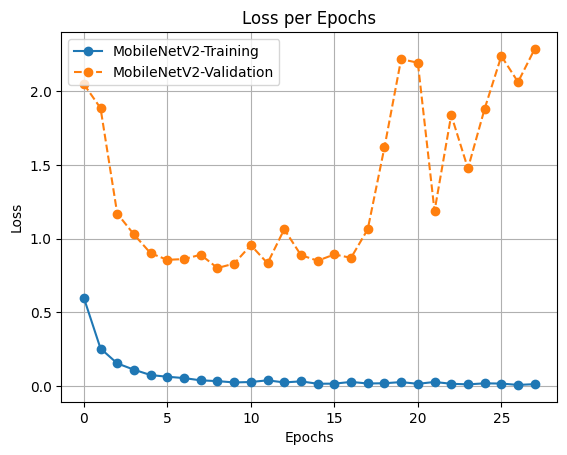

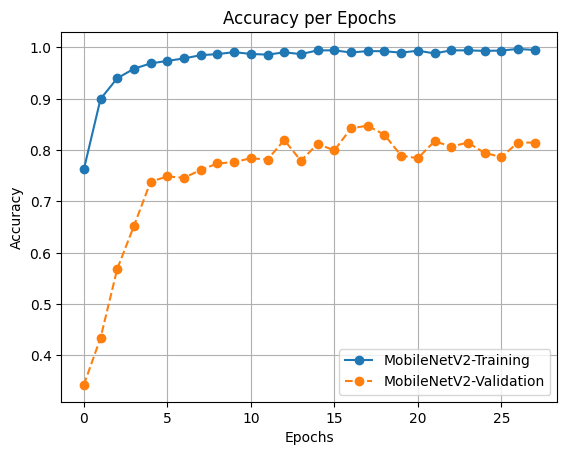

In [21]:
plt.plot(mobilenet_history.history['loss'], label='MobileNetV2-Training', marker='o')
plt.plot(mobilenet_history.history['val_loss'], label='MobileNetV2-Validation',linestyle='--', marker='o')
plt.title('Loss per Epochs') 
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


plt.plot(mobilenet_history.history['accuracy'], label='MobileNetV2-Training', marker='o')
plt.plot(mobilenet_history.history['val_accuracy'], label='MobileNetV2-Validation',linestyle='--', marker='o')
plt.title('Accuracy per Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 330ms/step


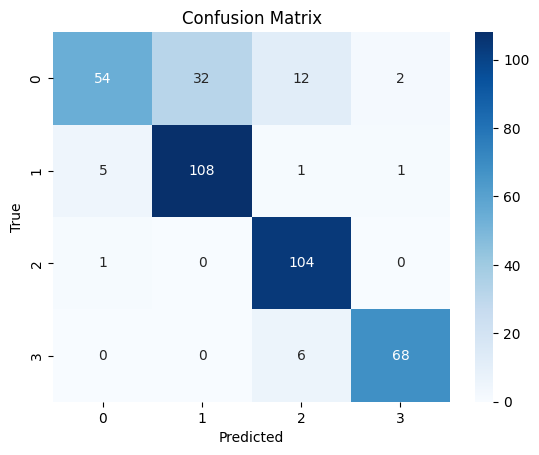

                  precision    recall  f1-score   support

    glioma_tumor       0.90      0.54      0.68       100
meningioma_tumor       0.77      0.94      0.85       115
        no_tumor       0.85      0.99      0.91       105
 pituitary_tumor       0.96      0.92      0.94        74

        accuracy                           0.85       394
       macro avg       0.87      0.85      0.84       394
    weighted avg       0.86      0.85      0.84       394



In [22]:
y_true = test.classes

y_pred_prob = mobilenet_model.predict(test)
y_pred = np.argmax(y_pred_prob, axis=1)

cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred, target_names = list(test.class_indices.keys())))

### Grad-Cam

In [14]:
from tensorflow.keras.models import load_model

mobilenet_model = load_model("/kaggle/input/mobilenetv2/tensorflow2/default/1/MobileNet_best_model.h5")

In [15]:
def grad_cam_heatmap(image_array, model, last_conv_name):
    grad_model = tf.keras.models.Model(
        [model.input],
        [model.get_layer(last_conv_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(image_array)
        pred_index = tf.argmax(predictions[0])
        top_class = predictions[:, pred_index]

    grads = tape.gradient(top_class, conv_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

    conv_output = conv_output[0].numpy()
    pooled_grads = pooled_grads.numpy()

    for i in range(pooled_grads.shape[-1]):
        conv_output[:,:,i] *= pooled_grads[i]

    heatmap = np.mean(conv_output, axis = -1)
    heatmap = np.maximum(heatmap,0)
    heatmap /= np.max(heatmap)

    return heatmap, pred_index.numpy()

In [16]:
from matplotlib import cm
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array

def superimposed_img(image, heatmap, alpha = 0.4):
    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:,:3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((image.shape[1], image.shape[0]))
    jet_heatmap = img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + image
    superimposed_img = array_to_img(superimposed_img)
    return superimposed_img

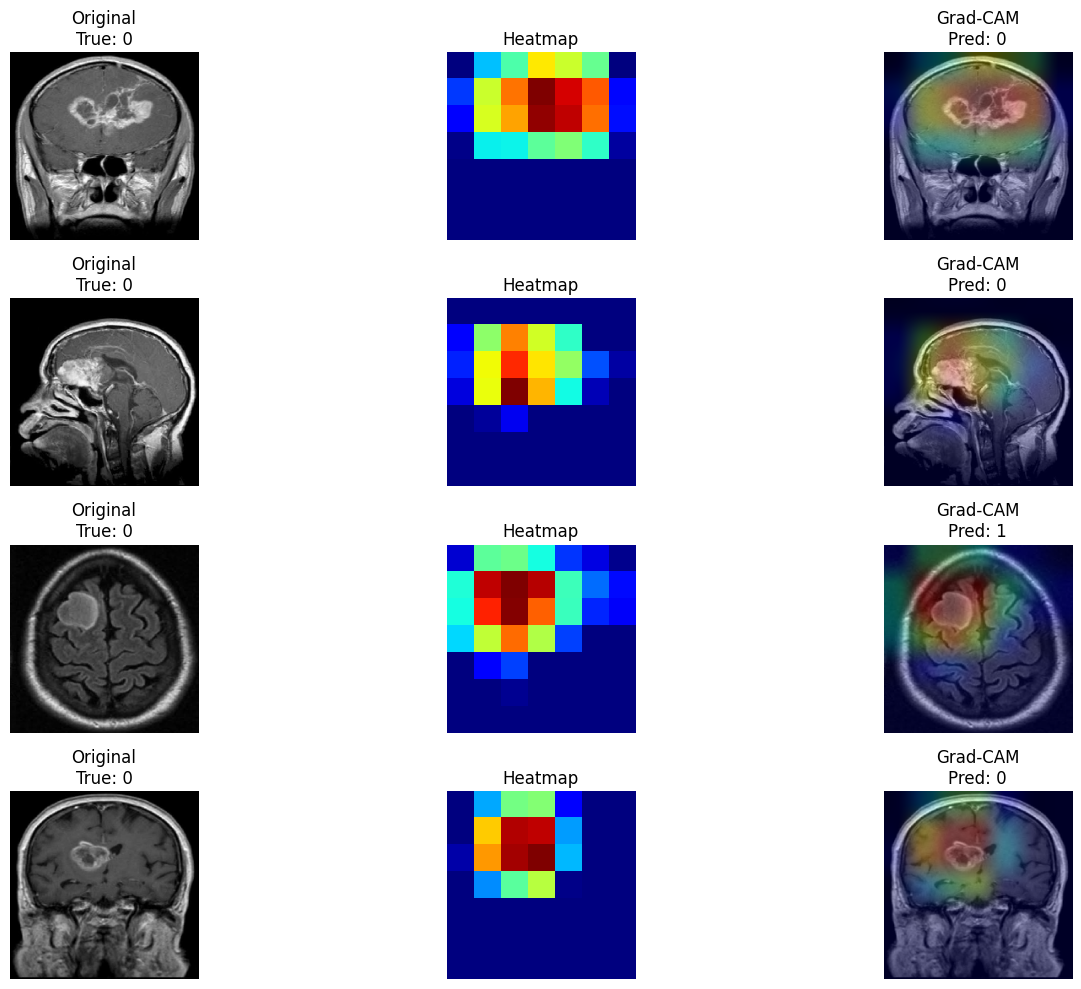

In [17]:
image_batch , label_batch = next(iter(test))
num_images = 4 
last_conv_layer_name = 'Conv_1'

plt.figure(figsize=(15,10))

for i in range(num_images):
    img = image_batch[i]
    img_array = np.expand_dims(img, axis=0)

    heatmap , pred_index = grad_cam_heatmap(img_array, mobilenet_model, last_conv_layer_name)

    overlay = superimposed_img(img*255, heatmap)

    plt.subplot(num_images, 3, 3*i + 1)
    plt.imshow(img)
    plt.title(f"Original\nTrue: {np.argmax(label_batch[i])}")
    plt.axis("off")

    plt.subplot(num_images, 3, 3*i + 2)
    plt.imshow(heatmap, cmap='jet')
    plt.title("Heatmap")
    plt.axis("off")

    plt.subplot(num_images, 3, 3*i + 3)
    plt.imshow(overlay)
    plt.title(f"Grad-CAM\nPred: {pred_index}")
    plt.axis("off")

plt.tight_layout()
plt.show()